In [1]:
# will need GPU to generate model embeddings

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-166d7783-762d-5f61-b31c-549eb4e0fba0"

In [2]:
import numpy as np
from collections import defaultdict
import torch
from scipy.stats import spearmanr

import sys
sys.path.append("../2_train_models")
from data_loading import extract_peaks
from file_configs import MergedFilesConfig, FoldFilesConfig
from BPNet_strand_merged_umap import Model

sys.path.append("../5_modisco")
from modiscolite_utils import load_observed_profiles, load_modisco_results

from common_functions import load_coords
from load_annotations_utils import find_peak_overlap_labels, get_ccre_bed
from motif_hits_utils import load_motif_hits

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

%matplotlib inline

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
# specify what set of models to look at
cell_type = "K562"

# the unique IDs for each of the folds / models in this cell type
timestamps = ["2023-05-29_15-51-40",
              "2023-05-29_15-58-41",
              "2023-05-29_15-59-09",
              "2023-05-30_01-40-06",
              "2023-05-29_23-21-23",
              "2023-05-29_23-23-45",
              "2023-05-29_23-24-11"]

# these usually don't change
model_type = "strand_merged_umap"
data_type = "procap"

# size of the model inputs and outputs
in_window = 2114
out_window = 1000

# motif names below are specific to the K562 profile modisco run
motif_names = ["BRE/SP", "CA-Inr", "ETS", "NFY", "NRF1", "ATF1", "TATA",
               "THAP11", "YY1", "AP1", "TA-Inr", "CTCF", "ZBTB33", "TCT", "TATATA"]

# what subset of the modisco results to look at (aligns with names)
patterns_to_keep = [0,1,2,3,4,5,6,7,8,9,13,15,19,21,23]

In [4]:
# Load the config object (filepaths holder) for when model outputs were merged across all folds

config = MergedFilesConfig(cell_type, model_type, data_type)

# these paths aren't specific to any model / fold, cell type, or data_type

proj_dir = config.proj_dir

figures_dir = proj_dir + "figures/"
os.makedirs(figures_dir, exist_ok=True)

In [5]:
coords = load_coords(config.all_peak_path, in_window=in_window)

In [6]:
# essentially, run bedtools intersect between PRO-cap peaks and cCRE annotations
# (takes a second to run)

# cCRE annotations are cell-type-specific, from ENCODE 2020 paper:
#  "Expanded encyclopaedias of DNA elements in the human and mouse genomes." (Nature)

ccre_annots = find_peak_overlap_labels(coords, get_ccre_bed(cell_type, proj_dir),
                                       in_window, out_window)

# break down category of "promoter" (PLS) into promoters
# with vs. without proximal enhancers (pELS)

ccre_annots["PLS_no_pELS"] = ccre_annots["PLS"] * (~ ccre_annots["pELS"])
ccre_annots["PLS_with_pELS"] = ccre_annots["PLS"] * ccre_annots["pELS"]

In [7]:
# load in sequences and observed data at all PRO-cap peaks

onehot_seqs, true_profs = extract_peaks(config.genome_path,
                                        config.chrom_sizes,
                                        config.plus_bw_path,
                                        config.minus_bw_path,
                                        config.all_peak_path,
                                        in_window=in_window,
                                        out_window=out_window,
                                        max_jitter=0,
                                        verbose=True)

true_counts = true_profs.sum(axis=(1,2))  # summing across strands and genomic axis

Loading genome sequence from /mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.fasta


Reading FASTA: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:08<00:00,  2.95it/s]
Loading Peaks: 30534it [00:40, 749.45it/s]


== In Extract Peaks ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Sequence length (with jitter): 2114
Profile length (with jitter): 1000
Max jitter applied: 0
Num. Examples: 30534
Mask loaded? False


In [8]:
# load model predictions for all peaks (generated by scripts in 3_eval_models/ folder)

pred_profs = np.exp(np.load(config.pred_profiles_all_path))
pred_counts = np.exp(np.load(config.pred_logcounts_all_path)).squeeze()

## Figure 4A: Model Embeddings

In [9]:
# re-define the model's forward func so that it returns output of intermediate layer

class BPNet_Embeddings_Loader(Model):
    def __init__(self, n_filters=512, n_layers=8, trimming=(in_window - out_window) // 2,
                 alpha=100):
        super().__init__("", n_filters=n_filters, n_layers=n_layers, trimming=trimming,
                         alpha=alpha)

    def forward(self, X):
        start, end = self.trimming, X.shape[2] - self.trimming

        X = self.relus[0](self.iconv(X))

        for i in range(self.n_layers):
            X_conv = self.relus[i+1](self.rconvs[i](X))
            X = torch.add(X, X_conv)
            
        X = X[:, :, start - self.deconv_kernel_size//2 : end + self.deconv_kernel_size//2]

        # return result of global avg pooling
        # (beginning of counts head, before linear layer)
        X = torch.mean(X, axis=2)
        return X
    
    
def get_embeddings(embedder, seqs, batch_size=128):
    # expecting seqs to be (num_peaks x 4 x sequence_length) array
    
    # if last two axes are transposed, fix
    if not seqs.shape[-2] == 4:
        seqs = np.swapaxes(seqs, -2, -1)
        
    # in batches, push sequences through the model, and collect embeddings
    # (takes about a minute on an A100)
    
    seqs = torch.tensor(seqs, dtype=torch.float)
    embedder = embedder.cuda()
    with torch.no_grad():
        starts = np.arange(0, seqs.shape[0], batch_size)
        ends = starts + batch_size

        embeds = []
        for i, (start, end) in enumerate(zip(starts, ends)):
            if i % 50 == 0:
                print("Batch " + str(i) + " of " + str(len(starts)))
            
            seqs_batch = seqs[start:end]
            embeds_batch = embedder(seqs_batch.cuda()).cpu().detach().numpy()
            embeds.append(embeds_batch)

    embedder = embedder.cpu()
    return np.concatenate(embeds)

def get_embeddings_all_folds(cell_type, timestamps, seqs, model_type=model_type, data_type=data_type):
    embeddings_all_folds = []
    
    for timestamp in timestamps:
        # fold # doesn't matter if you're just accessing the model by timestamp, so "1"
        fold_config = FoldFilesConfig(cell_type, model_type, "1", timestamp, data_type)
        
        # init the embeddings-output version of the model
        embedder = BPNet_Embeddings_Loader()
        # load the original trained model for this fold
        model = torch.load(fold_config.model_save_path)
        # copy model parameters over from the trained model to the embeddings-outputter
        embedder.load_state_dict(model.state_dict())
        embedder.eval()
        embedder = embedder.cuda()
        
        embeddings_all_folds.append(get_embeddings(embedder, seqs))
        
    return np.array(embeddings_all_folds).mean(axis=0)

all_embeds = get_embeddings_all_folds(cell_type, timestamps, onehot_seqs)

Timestamp: 2023-05-29_15-51-40
Batch 0 of 239
Batch 50 of 239
Batch 100 of 239
Batch 150 of 239
Batch 200 of 239
Timestamp: 2023-05-29_15-58-41
Batch 0 of 239
Batch 50 of 239
Batch 100 of 239
Batch 150 of 239
Batch 200 of 239
Timestamp: 2023-05-29_15-59-09
Batch 0 of 239
Batch 50 of 239
Batch 100 of 239
Batch 150 of 239
Batch 200 of 239
Timestamp: 2023-05-30_01-40-06
Batch 0 of 239
Batch 50 of 239
Batch 100 of 239
Batch 150 of 239
Batch 200 of 239
Timestamp: 2023-05-29_23-21-23
Batch 0 of 239
Batch 50 of 239
Batch 100 of 239
Batch 150 of 239
Batch 200 of 239
Timestamp: 2023-05-29_23-23-45
Batch 0 of 239
Batch 50 of 239
Batch 100 of 239
Batch 150 of 239
Batch 200 of 239
Timestamp: 2023-05-29_23-24-11
Batch 0 of 239
Batch 50 of 239
Batch 100 of 239
Batch 150 of 239
Batch 200 of 239


In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pcs = pca.fit(all_embeds)

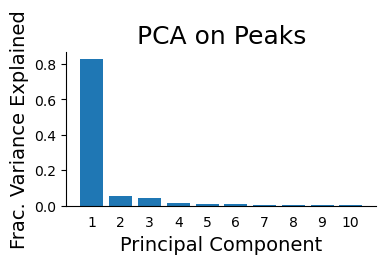

In [11]:
def plot_pc_frac_variances(pca_object):
    plt.figure(figsize=(4,2))
    plt.bar(range(1, 10+1), pca_object.explained_variance_ratio_)
    plt.xlabel("Principal Component", fontsize = 14)
    plt.ylabel("Frac. Variance Explained", fontsize = 14)
    plt.title("PCA on Peaks", fontsize = 18)

    plt.xticks(range(1, 10+1))
    plt.gca().spines[["right", "top"]].set_visible(False)
    plt.gca().xaxis.set_ticks_position('none') 

    plt.show()
    
plot_pc_frac_variances(pca)

In [12]:
sum(pca.explained_variance_ratio_[:2])

0.8835256360471249

In [13]:
all_embeds_pca_trans = pca.transform(all_embeds)

embeds_pca_trans = dict()
for annot_label in ["PLS", "PLS_with_pELS", "PLS_no_pELS", "dELS"]:
    embeds_pca_trans[annot_label] = all_embeds_pca_trans[ccre_annots[annot_label]]

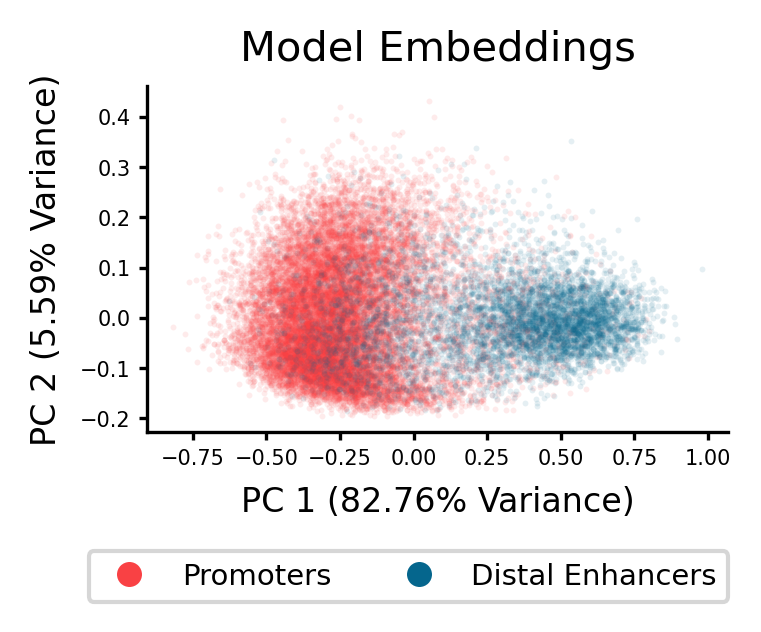

In [29]:
def plot_embeds_pca(embeds_pca, fracs_var_explained, save_path = None):
    annots_to_plot = ["PLS", "dELS"]
    annots_to_colors = {"PLS" : "#f94144", "dELS" : "#05668d"}
    annots_to_names = {"PLS" : "Promoters", "dELS" : "Distal Enhancers"}
    
    
    plt.figure(figsize=(2.5,1.5), dpi=300)

    legend_elements = []
    for annot in annots_to_plot:
        plt.scatter(embeds_pca[annot][..., 0], embeds_pca[annot][..., 1],
                    alpha = 0.1, s = 2, c=annots_to_colors[annot], linewidths=0)
        
        # make a custom dot for the legend
        # (needed because of how low-opacity the scatter dots are)
        legend_dot = Line2D([0], [0], label = annots_to_names[annot],
                            markerfacecolor = annots_to_colors[annot],
                            marker = 'o', color = 'w',
                            markersize = 7)
        legend_elements.append(legend_dot)


    plt.xlabel("PC 1 (%0.2f" % (fracs_var_explained[0] * 100) + "% Variance)",
               fontsize = 8)
    plt.ylabel("PC 2 (%0.2f" % (fracs_var_explained[1] * 100) + "% Variance)",
               fontsize = 8)
    plt.title("Model Embeddings", fontsize = 10)

    # aesthetics
    
    plt.gca().spines[["right", "top"]].set_visible(False)
    plt.tick_params("both", length=2, pad=2, labelsize = 5)

    plt.legend(handles=legend_elements, fontsize = 7, ncol=2,
               loc='upper center', bbox_to_anchor = (0.45, -0.3))

    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()
        
    
plot_embeds_pca(embeds_pca_trans, pca.explained_variance_ratio_, save_path = figures_dir + "4A_embeds.png")

## Figure 4B-4C: Motif Frequency in cCREs

In [30]:
# load motif hits

motif_hits, _, motif_hit_counts = load_motif_hits(cell_type, model_type, data_type,
                                                  in_window=in_window)

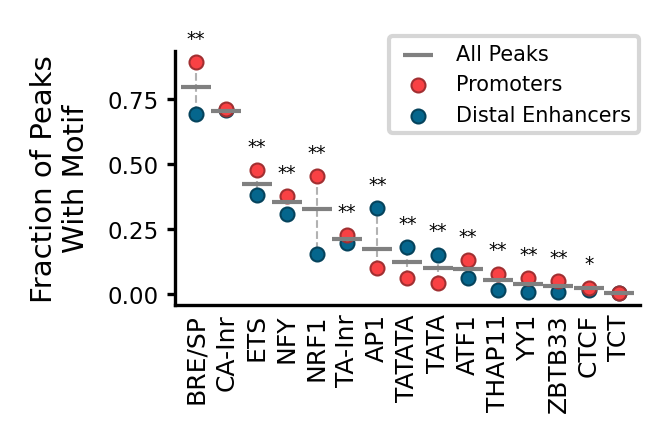

In [31]:
import scipy
from scipy.stats import permutation_test

def perm_test_diff_motif_fracs(pls_motifs, dels_motifs):
    # when we run a permutation test to assess the significance of
    # differences in motif presence between promoters and enhancers,
    # we have to give scipy a function for the statistic to test.
    
    # this function returns the difference between the fraction of
    # peaks with 1+ copies of a motif, for peaks overlapping promoters
    # vs. peaks overlapping enhancers
    
    return np.mean(pls_motifs) - np.mean(dels_motifs)



def plot_motif_enrichment_in_cCREs_condensed(motif_hit_counts, overlap_annots_bools,
                                             motif_names = motif_names,
                                             save_path = None):
    annots_to_plot = ["PLS", "dELS"]
    
    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal Enhancers",
                        "dELS" : "Distal Enhancers"}
    
    annots_to_colors = {"All Peaks" : "gray", "PLS" : "#f94144", "dELS" : "#05668d"}
    annots_to_edgecolors = {"All Peaks" : "gray", "PLS" : "#A12F31", "dELS" : "#05435C"}
    annots_to_sizes = {"All Peaks" : 50, "PLS" : 45, "dELS" : 45}
    
    assert len(motif_names) == motif_hit_counts.shape[1]
    motif_indexes = range(len(motif_names))
    num_peaks = motif_hit_counts.shape[0]
    
    # binarize motif hit counts in each peak: either a peak has the motif, or not
    
    motifs_in_peaks_binary = motif_hit_counts > 0
    
    # for each motif, compute:
    #  - the fraction of peaks with 1+ instances of that motif
    #  - the fraction of peaks *overlapping promoters* with 1+ instances of that motif
    #  - the fraction of peaks *overlapping enhancers* with 1+ instances of that motif
    #  - p-value for significance of the difference in motif-containing peak fractions,
    #      across promoters vs. enhancers
    
    annot_vals = defaultdict(lambda : [])  # this dict of lists collects motif fracs for each annot
    pvals = []  # collect pvals for each motif
    for motif_index in motif_indexes:
        total_peaks_with_motif = np.sum(motifs_in_peaks_binary[:, motif_index])

        annot_vals["All Peaks"].append(total_peaks_with_motif / num_peaks)
        
        for annot in annots_to_plot:
            num_overlap_peaks = np.sum(overlap_annots_bools[annot])
            num_overlap_peaks_with_motif = np.sum(motifs_in_peaks_binary[overlap_annots_bools[annot], motif_index])
            frac_peaks_with_motif_overlapping_annot = num_overlap_peaks_with_motif / num_overlap_peaks
            
            annot_vals[annot].append(frac_peaks_with_motif_overlapping_annot)
            
        # p-value calculation takes some time
        mwu_pval = scipy.stats.permutation_test((motifs_in_peaks_binary[ccre_annots["PLS"], motif_index],
                                                 motifs_in_peaks_binary[ccre_annots["dELS"], motif_index]),
                                                perm_test_diff_motif_fracs, n_resamples=9999).pvalue
        
        if mwu_pval <= 2e-4:
            pvals.append("**")
        elif mwu_pval < 0.01:
            pvals.append("*")
        else:
            pvals.append(" ")
            
        
    # what order to plot the motifs in: highest to lowest overall motif presence
    plot_order = np.argsort(annot_vals["All Peaks"])[::-1]
        
        
    plt.figure(figsize=(2.0, 1.1), dpi=300)
    
    # to avoid redundancy in the legend, only add labels to plotting actions once
    add_to_legend = True
    
    for y, plot_i in enumerate(plot_order):
        
        # first, plot the dashed line between the dots for promoters / enhancers
        
        plt.plot([y] * 2,
                 [annot_vals["PLS"][plot_i], annot_vals["dELS"][plot_i]],
                 color="gray", alpha = 0.6, linewidth=0.5, linestyle="dashed")
        
        # second, plot the marker for whether or not the diffences are significant above
        
        plt.text(y, 0.07 + max(annot_vals["PLS"][plot_i], annot_vals["dELS"][plot_i]),
                 pvals[plot_i],
                 fontsize=4.5, horizontalalignment="center")
        
        # third, plot the promoter/enhancer blue/red dots, and the gray marker for all
        
        for i, (key, vals) in enumerate(annot_vals.items()):
            if key == "All Peaks":
                # plot gray horizontal line marker for motif presence overall
                plt.scatter(y, vals[plot_i],
                            label=key if add_to_legend else "",
                            color=annots_to_colors[key],
                            linewidth=1,
                            s=annots_to_sizes[key],
                            zorder=10 - i, marker="_")
            else:
                # plot red/blue dot for promoter/enhancer motif presence
                plt.scatter(y, vals[plot_i],
                            label=annots_to_labels[key] if add_to_legend else "",
                            color=annots_to_colors[key],
                            edgecolor=annots_to_edgecolors[key],
                            linewidth=0.5,
                            s=annots_to_sizes[key],
                            zorder=10 - i, marker=".")
            
        add_to_legend = False  # everything has been added to legend once, so stop

    # aesthetics
        
    plt.legend(fontsize=5, loc="upper right", bbox_to_anchor=(1.02, 1.1))
    plt.ylabel("Fraction of Peaks\nWith Motif", fontsize=7)
    
    plt.xticks(motif_indexes, np.array(motif_names)[plot_order],
               fontsize=6, rotation=90)
    plt.yticks([0.0, 0.25, 0.5, 0.75], fontsize=5.5)
    plt.tick_params("y", length=2, pad=2)
    plt.tick_params("x", length=0, pad=2)
    
    plt.gca().spines[["top", "right"]].set_visible(False)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()
    

plot_motif_enrichment_in_cCREs_condensed(motif_hit_counts["profile"], ccre_annots,
                                        save_path = figures_dir + "4C_ccre_motif_fracs.png")

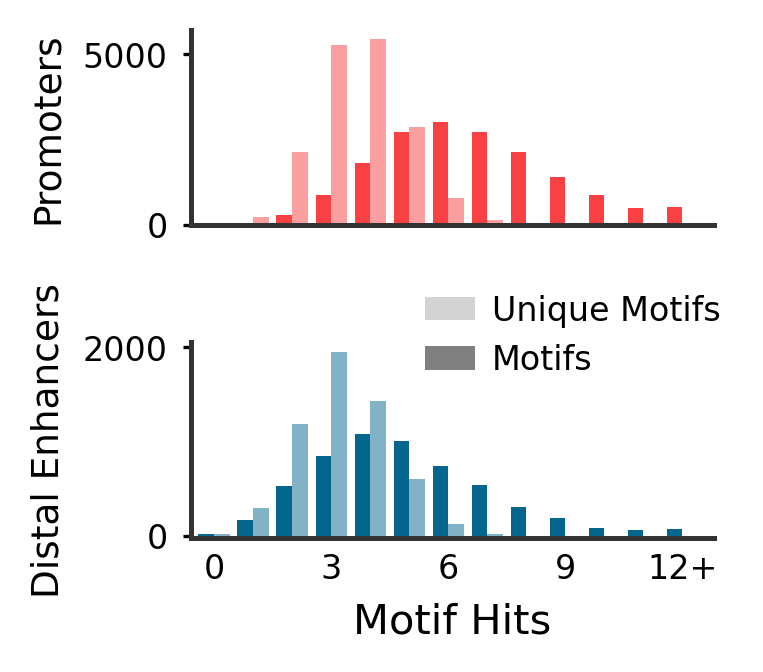

In [16]:
from matplotlib.patches import Patch


def plot_motif_complexity_across_ccres(motif_hit_counts, ccre_annots,
                                      save_path = None):
    annots_to_plot = ["PLS", "dELS"]
    
    annots_to_colors = {"PLS" : "#f94144", "dELS" : "#05668d"}

    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal Enhancers",
                        "dELS" : "Distal Enhancers"}
    bar_width = 0.4
    
    # because a small number of peaks have 15 or 16 motifs (thanks, SP1),
    # we want to clip and have the last histogram bin just be like "12+"
    last_hist_bin = 12
    
    # will make 1 subplot for promoters, one for enhancers
    
    fig, axes = plt.subplots(2, 1, figsize=(2.25,2.2), dpi=300, sharex=True)
    fig.subplots_adjust(hspace=0.6)
    
    for ax_i, key in enumerate(annots_to_plot):
        # get motif hits in peaks overlapping cCRE annotation
        motif_hit_counts_annot = motif_hit_counts[ccre_annots[key]]
        
        # sum hits across all motifs (to get total # motif hits per peak)
        motif_hits_per_peak = motif_hit_counts_annot.sum(axis=1)

        # count how many times we see different counts of motifs in peaks
        hist_y, hist_x = np.histogram(motif_hits_per_peak, bins=range(np.max(motif_hits_per_peak) + 2))

        # clip histogram so the last 5 bins 
        
        hist_y = list(hist_y[:last_hist_bin]) + [np.sum(hist_y[last_hist_bin:])]
        hist_x = list(hist_x[:last_hist_bin]) + [last_hist_bin]

        axes[ax_i].bar(hist_x, hist_y, color=annots_to_colors[key], width=bar_width)
        
        # then repeat for *unique* motifs
        
        # sum hits across all motifs, after binarizing (to get total # unique motif hits per peak)
        uniq_hits_per_peak = (motif_hit_counts_annot > 0).sum(axis=1)

        hist_y2, hist_x2 = np.histogram(uniq_hits_per_peak, bins=range(np.max(uniq_hits_per_peak) + 2))
        
        axes[ax_i].bar(hist_x2[:-1] + bar_width, hist_y2, color=annots_to_colors[key], width=bar_width, alpha=0.5)

        # aesthetics
        
        axes[ax_i].set_ylabel(annots_to_labels[key], fontsize=9)
        
        if ax_i == len(annots_to_plot) - 1:
            axes[ax_i].set_xlabel("Motif Hits", fontsize=10)
        
            xticklabels = []
            for i in hist_x:
                if i < last_hist_bin:
                    xticklabels.append(str(i))
                else:
                    xticklabels.append(str(last_hist_bin) + "+")

            axes[ax_i].set_xticks(np.array(hist_x[::3]) + bar_width / 2, xticklabels[::3])
            axes[ax_i].set_xlim(-bar_width, len(hist_x))
            
            # arbitrarily small negative value so the axis line doesn't cover small bars
            axes[ax_i].set_ylim(-20, axes[ax_i].get_ylim()[1])
            
        axes[ax_i].tick_params("x", labelsize=8, length=0)
        axes[ax_i].tick_params("y", labelsize=8, length=2)

        axes[ax_i].spines[["left", "bottom"]].set_linewidth(1.2)
        axes[ax_i].spines[["left", "bottom"]].set_color("#333333")
        axes[ax_i].spines[["top", "right"]].set_visible(False)


    legend_elements = [Patch(facecolor='lightgray', label='Unique Motifs'),
                       Patch(facecolor='gray', label='Motifs')]

    axes[-1].legend(handles=legend_elements, fontsize=8, bbox_to_anchor=(0,0,1.07,1.4),
                   loc='upper right', frameon=False, handletextpad=0.5, handlelength=1.5)
            
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()


plot_motif_complexity_across_ccres(motif_hit_counts["profile"], ccre_annots,
                                  save_path = figures_dir + "4C_ccre_complexity.png")

## Can Motif Hits Distinguish cCREs?

In [17]:
from sklearn.linear_model import LogisticRegression

# try fitting a logistic regression model to predict promoter vs. enhancer
# using motif hit countss

either_promoter_or_enhancer_peaks = np.logical_or(ccre_annots["PLS"], ccre_annots["dELS"])
motif_hit_counts_ccres = motif_hit_counts["profile"][either_promoter_or_enhancer_peaks]
promoter_labels = ccre_annots["PLS"][either_promoter_or_enhancer_peaks]

lrm = LogisticRegression(penalty='none').fit(motif_hit_counts_ccres, promoter_labels)

print("Accuracy of LR classifier (promoter vs. enhancer):")
print(lrm.score(motif_hit_counts_ccres, promoter_labels))

print("\nCoefficients of each motif in LR model:")

for motif_i, motif_name in enumerate(motif_names):
    print(motif_name, "%0.3f" % (lrm.coef_.squeeze()[motif_i]))

Accuracy of LR classifier (promoter vs. enhancer):
0.8190021231422505

Coefficients of each motif in LR model:
BRE/SP 0.317
CA-Inr 0.112
ETS 0.419
NFY 0.370
NRF1 0.907
ATF1 0.760
TATA -0.723
THAP11 1.259
YY1 1.872
AP1 -0.880
TA-Inr 0.148
CTCF 0.024
ZBTB33 1.364
TCT 0.522
TATATA -0.523


In [18]:
# try again, but this time, binarize motif hits (1+ motif hits = 1, 0 otherwise)

lrm2 = LogisticRegression(penalty='none').fit(motif_hit_counts_ccres > 0, promoter_labels)

print("Accuracy of LR classifier (promoter vs. enhancer), binarized motif hits:")
print(lrm2.score(motif_hit_counts_ccres, promoter_labels))

print("\nCoefficients of each motif in LR model:")

for motif_i, motif_name in enumerate(motif_names):
    print(motif_name, "%0.3f" % (lrm2.coef_.squeeze()[motif_i]))

Accuracy of LR classifier (promoter vs. enhancer), binarized motif hits:
0.8061305732484076

Coefficients of each motif in LR model:
BRE/SP 1.148
CA-Inr 0.087
ETS 0.415
NFY 0.431
NRF1 1.327
ATF1 0.743
TATA -0.964
THAP11 1.512
YY1 2.021
AP1 -1.159
TA-Inr 0.139
CTCF 0.068
ZBTB33 1.468
TCT 0.600
TATATA -0.701


## Motif Instance Similarity to CWM Across cCREs

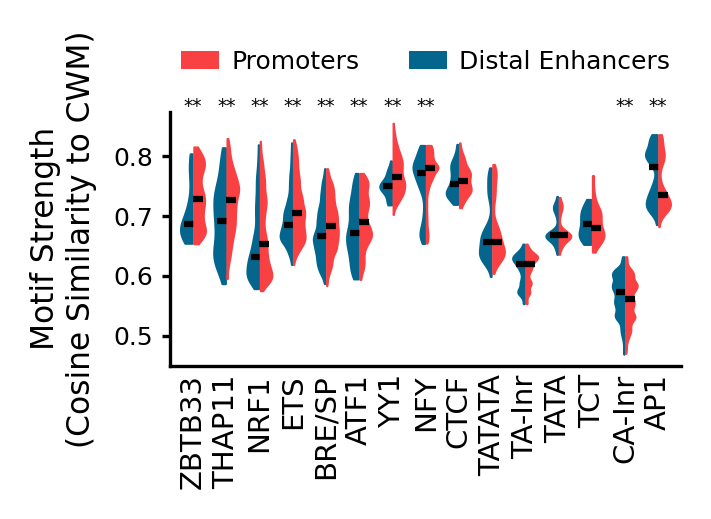

In [27]:
from other_motif_utils import trim_motif_by_thresh


def score_seq_by_cwm(cwm, seq):
    # this computes the cosine similarity between the cwm matrix
    # and the sequence in its one-hot encoding form.
    
    # if seq is not already one-hot encoded, encode
    if type(seq) == str:
        seq = one_hot_encode(seq)
        
    assert cwm.shape == seq.shape
    
    # numerator = dot product, denominator = product of magnitudes
    return np.multiply(seq, cwm).sum() / (np.linalg.norm(seq) * np.linalg.norm(cwm))


def extract_seqs_at_motifs(motif_hits, coords, onehot_seqs, in_window, buffer_width = 200):
        
    assert len(onehot_seqs.shape) == 3 and onehot_seqs.shape[1] == 4, onehot_seqs.shape
    seq_len = onehot_seqs.shape[-1]
    
    def convert_motif_coords_to_seq_coords(coords, peak_indexes, motif_starts, motif_ends):
        # motif hits are represented as genomic coordinates, but we need to know where
        # in the sequence centered at a PRO-cap peak they were found, in order to extract
        # the actual sequence at that position.
        real_starts = []
        real_ends = []
        for peak_index, start, end in zip(peak_indexes, motif_starts, motif_ends):
            peak_coords = coords[peak_index]
            peak_start, peak_end = peak_coords[1:3]
            # subtract genomic start coordinate of peak from the genomic start coord of motif,
            # to get where in the peak sequence window the motif is
            real_start = start - peak_start# - (in_window - seq_len) // 2  # please be the same
            real_starts.append(real_start)
            real_ends.append(real_start + (end - start))

        return np.array(real_starts), np.array(real_ends)
        
    peak_indexes = motif_hits["peak_index"]
    # because the hit caller pads by 2...
    genomic_motif_starts = motif_hits["start"] - 2
    genomic_motif_ends = motif_hits["end"] + 2
    
    motif_rcs = motif_hits["strand"] == "-"
    
    motif_starts, motif_ends = convert_motif_coords_to_seq_coords(coords, peak_indexes,
                                                                  genomic_motif_starts,
                                                                  genomic_motif_ends)

    # For each seqlet, fetch the actual sequence at that location
    motif_seqs = []
    for peak_index, motif_start, motif_end, rc in zip(peak_indexes, motif_starts, motif_ends, motif_rcs):
        motif_mid = (motif_start + motif_end) // 2
        assert not (motif_mid - buffer_width < 0 or motif_mid + buffer_width > seq_len)
        
        seq = onehot_seqs[peak_index, :, motif_start:motif_end]
        
        # if the motif was found in orientation opposite the CWM, flip
        if rc:
            seq = seq[::-1, ::-1]
        motif_seqs.append(seq)
    
    motif_seqs = np.stack(motif_seqs)
    return motif_seqs


def calc_motif_strengths(modisco_results_path, onehot_seqs, patterns_to_keep,
                         motif_hits, coords, in_window, prof_width=200):

    modisco_results = load_modisco_results(modisco_results_path)
    
    pattern_type = "pos_patterns"
    patterns = modisco_results[pattern_type]

    # for each motif...
    # (in modisco results, motifs are named by a pattern index)
    cwm_score_list = []
    for ax_row_i, pattern_i in enumerate(patterns_to_keep):
        pattern_name = "pattern_" + str(pattern_i)
        pattern = patterns[pattern_name]

        # remove the extra, low-IC bases modisco adds to all hits
        cwm_trimmed = trim_motif_by_thresh(pattern["contrib_scores"][:], trim_threshold=0.2, pad=2)
        cwm_trimmed = cwm_trimmed / np.sum(cwm_trimmed)
        
        # do ax_row_i here because the motif hit caller only saw filtered subset of motifs
        motif_hits_subset = motif_hits[motif_hits["motif_index"] == ax_row_i]
        
        # get the actual genomic sequences at every motif instance
        motif_seqs = extract_seqs_at_motifs(motif_hits_subset, coords,
                                            onehot_seqs, in_window, buffer_width=prof_width)

        # calculate how close the motif instances match the CWM for the motif
        seq_scores = np.array([score_seq_by_cwm(cwm_trimmed, seq.T) for seq in motif_seqs])
        cwm_score_list.append(seq_scores)
        
    return cwm_score_list


def subset_motif_hits_by_ccre(motif_hits, ccre_bools):
    # takes the set of motif hits over the entire dataset (a pandas dataframe),
    # and filters for only the ones found in the peaks overlapping a cCRE
    peak_indexes_with_ccre = np.where(ccre_bools)[0]
    return motif_hits[motif_hits["peak_index"].isin(peak_indexes_with_ccre)]


def make_violinplot_halved(violinplot, color, left=False):
    # converts a matplotlib violinplot object to just half of a violinplot
    #  - if left=True, draws the left half; by default, draws the right half
    
    for b in violinplot['bodies']:
        # get the center
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        
        if left:
            # modify the paths to not go further right than the center
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], - np.inf, m)
        else:
            # modify the paths to not go further left than the center
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)

        b.set_edgecolor(color)
        b.set_facecolor(color)
        b.set_alpha(1)
        b.set_linewidth(0.5)
        
        
def plot_motif_strengths_by_ccre(modisco_results_path, onehot_seqs,
                                 patterns_to_keep, motif_hits, coords,
                                 in_window, ccre_annots, save_path=None):
    
    annots_to_colors = {"PLS" : "#f94144", "dELS" : "#05668d"}

    annots_to_labels = {"PLS" : "Promoters",
                        "dELS" : "Distal Enhancers"}
    
    all_motif_strengths = dict()
    median_motif_strengths = dict()
    
    for annot in ["PLS", "dELS"]:
        # get all motif hits in PRO-cap peaks overlapping this cCRE type
        motif_hits_for_annot = subset_motif_hits_by_ccre(motif_hits, ccre_annots[annot])

        # calculate how similar each motif hit is to the CWM for the motif
        motif_strengths = calc_motif_strengths(modisco_results_path, onehot_seqs,
                                               patterns_to_keep, motif_hits_for_annot,
                                               coords, in_window)
        
        all_motif_strengths[annot] = np.array(motif_strengths, dtype=object)
        median_motif_strengths[annot] = np.array([np.median(strengths) for strengths in motif_strengths])
    
    # the x-axis ordering should go from most to least enriched in promoters
    plot_order = np.argsort(median_motif_strengths["dELS"] - median_motif_strengths["PLS"])
    num_motifs = len(all_motif_strengths["PLS"])
    
    # calculate significance of the difference in motif strengths
    # between promoters and enhancers, for each motif
    
    pvals = []
    for motif_i in range(num_motifs):
        mwu_pval = scipy.stats.mannwhitneyu(all_motif_strengths["PLS"][motif_i],
                                         all_motif_strengths["dELS"][motif_i]).pvalue
        if mwu_pval < 0.0001:
            pvals.append("**")
        elif mwu_pval < 0.01:
            pvals.append("*")
        else:
            pvals.append(" ")
            
    pvals = np.array(pvals)[plot_order]
    
    
    plt.figure(figsize=(2.2,1.1), dpi=300)

    v2 = plt.violinplot(all_motif_strengths["dELS"][plot_order], points=500,
                       positions=np.arange(num_motifs) - 0.03,
                       showmeans=False, showextrema=False, showmedians=False,
                       widths=0.7)
    
    make_violinplot_halved(v2, annots_to_colors["dELS"], left=True)

    plt.scatter(np.arange(num_motifs) - 0.12, median_motif_strengths["dELS"][plot_order],
                marker="_", c="k", s=5, zorder=1)
    
    
    v1 = plt.violinplot(all_motif_strengths["PLS"][plot_order], points=500,
                       positions=np.arange(num_motifs) + 0.02,
                       showmeans=False, showextrema=False, showmedians=False,
                       widths=0.7)
    
    make_violinplot_halved(v1, annots_to_colors["PLS"])

    # draw on medians for each violinplot
    plt.scatter(np.arange(num_motifs) + 0.14, median_motif_strengths["PLS"][plot_order],
                marker="_", c="k", s=5, zorder=1)
    
    
    # draw pval indicators
    for i in range(len(pvals)):
        plt.text(i, plt.gca().get_ylim()[1], pvals[i],
                 fontsize=4.5, horizontalalignment="center")
    
    # aesthetics
    
    plt.ylabel("Motif Strength\n(Cosine Similarity to CWM)", fontsize=7.5)
    
    plt.xticks(np.arange(num_motifs), np.array(motif_names)[plot_order],
               rotation=90, fontsize=7)
    
    plt.tick_params("x", length=0, pad=2)
    plt.tick_params("y", labelsize=6, length=2, pad=2)
    plt.xlim(-0.7, num_motifs - 0.3)
    
    plt.gca().spines[["top", "right"]].set_visible(False)

    legend_elements = [Patch(facecolor=annots_to_colors["PLS"], label='Promoters'),
                       Patch(facecolor=annots_to_colors["dELS"], label='Distal Enhancers')]

    plt.legend(handles=legend_elements, fontsize=6, bbox_to_anchor=(0.5, 1.06), ncol=2,
                   loc='lower center', frameon=False, handletextpad=0.5, handlelength=1.5)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    
    plt.show()
        
        
plot_motif_strengths_by_ccre(config.modisco_profile_results_path, onehot_seqs,
                             patterns_to_keep, motif_hits["profile"], coords,
                             in_window, ccre_annots,
                             save_path=figures_dir + "4E_ccre_motif_strengths.png")

## Promoter-Only Model Analysis

In [28]:
from file_configs_promoters_only import PromotersOnlyFoldFilesConfig
from file_configs import FoldFilesConfig

promoters_only_timestamps = ["2024-01-11_04-16-09", "2024-01-11_05-41-04",
                             "2024-01-11_06-46-15", "2024-01-11_07-54-30",
                             "2024-01-11_09-03-11", "2024-01-11_10-25-53",
                             "2024-01-11_11-44-28"]

repeat_timestamps = ["2024-02-18_01-26-07", "2024-02-18_03-00-29",
                     "2024-02-18_04-50-55", "2024-02-18_06-47-37",
                     "2024-02-18_08-43-12", "2024-02-18_10-37-54",
                     "2024-02-18_12-18-54"]

timestamps = ["2023-05-29_15-51-40",
              "2023-05-29_15-58-41",
              "2023-05-29_15-59-09",
              "2023-05-30_01-40-06",
              "2023-05-29_23-21-23",
              "2023-05-29_23-23-45",
              "2023-05-29_23-24-11"]


def load_fold_configs(timestamps, model_type = "strand_merged_umap"):
    data_type = "procap"
    cell_type = "K562"
    
    configs = []
    for i, timestamp in enumerate(timestamps):
        fold = str(i + 1)
        if "promoters_only" in model_type:
            config = PromotersOnlyFoldFilesConfig(cell_type, model_type, fold, timestamp, data_type)
        else:
            config = FoldFilesConfig(cell_type, model_type, fold, timestamp, data_type)
            
        configs.append(config)
    return configs

promoters_only_fold_configs = load_fold_configs(promoters_only_timestamps,
                                                model_type = "promoters_only_strand_merged_umap")

repeat_fold_configs = load_fold_configs(repeat_timestamps, model_type = "strand_merged_umap_replicate")
original_fold_configs = load_fold_configs(timestamps)

Timestamp: 2024-01-11_04-16-09
Timestamp: 2024-01-11_05-41-04
Timestamp: 2024-01-11_06-46-15
Timestamp: 2024-01-11_07-54-30
Timestamp: 2024-01-11_09-03-11
Timestamp: 2024-01-11_10-25-53
Timestamp: 2024-01-11_11-44-28
Timestamp: 2024-02-18_01-26-07
Timestamp: 2024-02-18_03-00-29
Timestamp: 2024-02-18_04-50-55
Timestamp: 2024-02-18_06-47-37
Timestamp: 2024-02-18_08-43-12
Timestamp: 2024-02-18_10-37-54
Timestamp: 2024-02-18_12-18-54
Timestamp: 2023-05-29_15-51-40
Timestamp: 2023-05-29_15-58-41
Timestamp: 2023-05-29_15-59-09
Timestamp: 2023-05-30_01-40-06
Timestamp: 2023-05-29_23-21-23
Timestamp: 2023-05-29_23-23-45
Timestamp: 2023-05-29_23-24-11


In [29]:
def load_pred_logcounts(config):
    return np.load(config.pred_logcounts_test_path).squeeze()

def load_pred_profiles_flat(config):
    return np.exp(np.load(config.pred_profiles_test_path)).squeeze().flatten()


def get_preds_corrs_one_fold(config1, config2, profile=False):
    if profile:
        preds1 = load_pred_profiles_flat(config1)
        preds2 = load_pred_profiles_flat(config2)
    else:
        preds1 = load_pred_logcounts(config1)
        preds2 = load_pred_logcounts(config2)
    
    assert preds1.shape == preds2.shape
    
    pearson = np.corrcoef(preds1, preds2)[0,1]
    spearman = spearmanr(preds1, preds2).correlation
    return pearson, spearman
    
    
def get_stddevs_corrs_all_folds(configs1, configs2, profile=False):
    corrs = []
    for config1, config2 in zip(configs1, configs2):
        corrs.append(get_preds_corrs_one_fold(config1, config2, profile=profile))
        
    pearsons, spearmans = zip(*corrs)
    return np.std(pearsons), np.std(spearmans) 


def get_pvals_corrs_all_folds(configs1, configs2, replicate_configs2, profile=False):
    corrs_expt = []
    for config1, config2 in zip(configs1, configs2):
        corrs_expt.append(get_preds_corrs_one_fold(config1, config2, profile=profile))
    pearsons_expt, spearmans_expt = zip(*corrs_expt) 
        
    corrs_replicate = []
    for config2, config3 in zip(configs2, replicate_configs2):
        corrs_replicate.append(get_preds_corrs_one_fold(config2, config3, profile=profile))
    pearsons_replicate, spearmans_replicate = zip(*corrs_replicate) 
    
    pearson_pval = scipy.stats.wilcoxon(pearsons_expt, pearsons_replicate).pvalue
    spearman_pval = scipy.stats.wilcoxon(spearmans_expt, spearmans_replicate).pvalue

    return pearson_pval, spearman_pval


def get_preds_corrs_all_folds(configs1, configs2, profile=False):
    preds1 = []
    preds2 = []
    for config1, config2 in zip(configs1, configs2):
        if profile:
            preds1.extend(load_pred_profiles_flat(config1))
            preds2.extend(load_pred_profiles_flat(config2))
        else:
            preds1.extend(load_pred_logcounts(config1))
            preds2.extend(load_pred_logcounts(config2))
    
    preds1 = np.array(preds1)
    preds2 = np.array(preds2)
    assert preds1.shape == preds2.shape
    
    pearson = np.corrcoef(preds1, preds2)[0,1]
    spearman = spearmanr(preds1, preds2).correlation
    return pearson, spearman


def calc_everything(configs1, configs2, replicate_configs2):
    stats = defaultdict(lambda : defaultdict(lambda : defaultdict( lambda : dict())))
    for task in [False, True]:
        if task:
            print("\n===   Profile Task   ===")
        else:
            print("\n===   Counts Task   ===")
    
        print("\nPromoter vs. Original:")
    
        pearson, spearman = get_preds_corrs_all_folds(configs1, configs2, profile=task)
        stats["promoter_vs_original"][task]["corr"]["pearson"] = pearson
        stats["promoter_vs_original"][task]["corr"]["spearman"] = spearman
        print("Corrs:   \t%0.3f\t%0.3f" % (pearson, spearman))
    
        pearson, spearman = get_stddevs_corrs_all_folds(configs1, configs2, profile=task)
        stats["promoter_vs_original"][task]["stddev"]["pearson"] = pearson
        stats["promoter_vs_original"][task]["stddev"]["spearman"] = spearman
        print("Std devs:\t%0.3f\t%0.3f" % (pearson, spearman))
        
        print("\nReplicate vs. Original:")
        
        pearson, spearman = get_preds_corrs_all_folds(replicate_configs2, configs2, profile=task)
        stats["replicate_vs_original"][task]["corr"]["pearson"] = pearson
        stats["replicate_vs_original"][task]["corr"]["spearman"] = spearman
        print("Corrs:   \t%0.3f\t%0.3f" % (pearson, spearman))
    
        pearson, spearman = get_stddevs_corrs_all_folds(replicate_configs2, configs2, profile=task)
        stats["replicate_vs_original"][task]["stddev"]["pearson"] = pearson
        stats["replicate_vs_original"][task]["stddev"]["spearman"] = spearman
        print("Std devs:\t%0.3f\t%0.3f" % (pearson, spearman))

        pearson, spearman = get_pvals_corrs_all_folds(configs1, configs2, replicate_configs2, profile=task)
        stats["pvals"][task]["pearson"] = pearson
        stats["pvals"][task]["spearman"] = spearman
        print("\nP-values:\t%0.3f\t%0.3f" % (pearson, spearman))
        
    return stats

        
promoter_only_model_stats = calc_everything(promoters_only_fold_configs, original_fold_configs, repeat_fold_configs)


===   Counts Task   ===

Promoter vs. Original:
Corrs:   	0.916	0.941
Std devs:	0.015	0.011

Replicate vs. Original:
Corrs:   	0.976	0.974
Std devs:	0.005	0.005

P-values:	0.016	0.016

===   Profile Task   ===

Promoter vs. Original:
Corrs:   	0.881	0.930
Std devs:	0.006	0.006

Replicate vs. Original:
Corrs:   	0.898	0.943
Std devs:	0.004	0.002

P-values:	0.016	0.016


In [30]:
def load_deepshaps(config, profile=False):
    if profile:
        scores = np.load(config.profile_onehot_scores_path).sum(axis=1)
    else:
        scores = np.load(config.counts_onehot_scores_path).sum(axis=1)
        
    # slicing to central 1000bp because there probably won't be much past that
    scores = scores[..., in_window // 2 - 500 : in_window // 2 + 500].flatten()
    return scores


def get_attrs_corrs_one_fold(config1, config2, profile=False):
    scores1 = load_deepshaps(config1, profile=profile)
    scores2 = load_deepshaps(config2, profile=profile)
    
    assert scores1.shape == scores2.shape
    
    pearson = np.corrcoef(scores1, scores2)[0,1]
    spearman = spearmanr(scores1, scores2).correlation
    return pearson, spearman
    
    
def get_stddevs_attrs_corrs_all_folds(configs1, configs2, profile=False):
    corrs = []
    for config1, config2 in zip(configs1, configs2):
        corrs.append(get_attrs_corrs_one_fold(config1, config2, profile=profile))
        
    pearsons, spearmans = zip(*corrs)
    return np.std(pearsons), np.std(spearmans) 


def get_pvals_attrs_corrs_all_folds(configs1, configs2, replicate_configs2, profile=False):
    corrs_expt = []
    for config1, config2 in zip(configs1, configs2):
        corrs_expt.append(get_attrs_corrs_one_fold(config1, config2, profile=profile))
    pearsons_expt, spearmans_expt = zip(*corrs_expt) 
        
    corrs_replicate = []
    for config2, config3 in zip(configs2, replicate_configs2):
        corrs_replicate.append(get_attrs_corrs_one_fold(config2, config3, profile=profile))
    pearsons_replicate, spearmans_replicate = zip(*corrs_replicate) 
    
    pearson_pval = scipy.stats.wilcoxon(pearsons_expt, pearsons_replicate).pvalue
    spearman_pval = scipy.stats.wilcoxon(spearmans_expt, spearmans_replicate).pvalue

    return pearson_pval, spearman_pval


def get_attrs_corrs_all_folds(configs1, configs2, profile=False):
    scores1 = []
    scores2 = []
    for config1, config2 in zip(configs1, configs2):
        scores1.extend(load_deepshaps(config1, profile=profile))
        scores2.extend(load_deepshaps(config2, profile=profile))
    
    scores1 = np.array(scores1)
    scores2 = np.array(scores2)
    assert scores1.shape == scores2.shape
    
    pearson = np.corrcoef(scores1, scores2)[0,1]
    spearman = spearmanr(scores1, scores2).correlation
    return pearson, spearman


def calc_everything_scores(configs1, configs2, replicate_configs2):
    stats = defaultdict(lambda : defaultdict(lambda : defaultdict( lambda : dict())))
    for task in [False, True]:
        if task:
            print("\n===   Profile Task   ===")
        else:
            print("\n===   Counts Task   ===")
    
        print("\nPromoter vs. Original:")
    
        pearson, spearman = get_attrs_corrs_all_folds(configs1, configs2, profile=task)
        stats["promoter_vs_original"][task]["corr"]["pearson"] = pearson
        stats["promoter_vs_original"][task]["corr"]["spearman"] = spearman
        print("Corrs:   \t%0.3f\t%0.3f" % (pearson, spearman))
    
        pearson, spearman = get_stddevs_attrs_corrs_all_folds(configs1, configs2, profile=task)
        stats["promoter_vs_original"][task]["stddev"]["pearson"] = pearson
        stats["promoter_vs_original"][task]["stddev"]["spearman"] = spearman
        print("Std devs:\t%0.3f\t%0.3f" % (pearson, spearman))
        
        print("\nReplicate vs. Original:")
        
        pearson, spearman = get_attrs_corrs_all_folds(replicate_configs2, configs2, profile=task)
        stats["replicate_vs_original"][task]["corr"]["pearson"] = pearson
        stats["replicate_vs_original"][task]["corr"]["spearman"] = spearman
        print("Corrs:   \t%0.3f\t%0.3f" % (pearson, spearman))
    
        pearson, spearman = get_stddevs_attrs_corrs_all_folds(replicate_configs2, configs2, profile=task)
        stats["replicate_vs_original"][task]["stddev"]["pearson"] = pearson
        stats["replicate_vs_original"][task]["stddev"]["spearman"] = spearman
        print("Std devs:\t%0.3f\t%0.3f" % (pearson, spearman))

        pearson, spearman = get_pvals_attrs_corrs_all_folds(configs1, configs2, replicate_configs2, profile=task)
        stats["pvals"][task]["pearson"] = pearson
        stats["pvals"][task]["spearman"] = spearman
        print("\nP-values:\t%0.3f\t%0.3f" % (pearson, spearman))
        
    return stats

        
promoter_only_model_stats_scores = calc_everything_scores(promoters_only_fold_configs,
                                                          original_fold_configs,
                                                          repeat_fold_configs)


===   Counts Task   ===

Promoter vs. Original:
Corrs:   	0.692	0.659
Std devs:	0.033	0.030

Replicate vs. Original:
Corrs:   	0.844	0.807
Std devs:	0.018	0.020

P-values:	0.016	0.016

===   Profile Task   ===

Promoter vs. Original:
Corrs:   	0.840	0.726
Std devs:	0.010	0.021

Replicate vs. Original:
Corrs:   	0.875	0.775
Std devs:	0.005	0.007

P-values:	0.016	0.016


In [31]:
def print_table(stats, stats_scores):
    # to make life easier, this function prints out all the info
    # calculated above in the form of a latex table, so I can just
    # copy-paste the whole thing into overleaf if numbers change.
    
    rownames = ["Counts Predictions", "Profile Predictions",
                "Counts Contribution Scores", "Profile Contribution Scores"]
    
    row1 = []
    row2 = []
    row3 = []
    row4 = []
    for comparison in ["replicate_vs_original", "promoter_vs_original"]:
        for correlation_type in ["pearson", "spearman"]:
            for corr_or_stddev in ["corr", "stddev"]:
                # counts, then profile
                row1.append(stats[comparison][False][corr_or_stddev][correlation_type])
                row2.append(stats[comparison][True][corr_or_stddev][correlation_type])
                
                row3.append(stats_scores[comparison][False][corr_or_stddev][correlation_type])
                row4.append(stats_scores[comparison][True][corr_or_stddev][correlation_type])
                
    rows_data = [row1, row2, row3, row4]
    
    for row_i, (row_data, rowname) in enumerate(zip(rows_data, rownames)):
        row_means = [val for col_i, val in enumerate(row_data) if col_i % 2 == 0]
        row_stddevs = [val for col_i, val in enumerate(row_data) if col_i % 2 == 1]
        
        row_as_str = [rowname]
        for mean, stddev in zip(row_means, row_stddevs):
            row_as_str.append("%0.3f" % (mean) + " (%0.3f)" % (stddev))
        
        row_as_str = " & ".join(row_as_str)
        
        if row_i < len(rows_data) - 1:
            print(row_as_str + r' \\')
        else:
            print(row_as_str + r'\label{Tab2}\\')

print_table(promoter_only_model_stats, promoter_only_model_stats_scores)

Counts Predictions & 0.976 (0.005) & 0.974 (0.005) & 0.916 (0.015) & 0.941 (0.011) \\
Profile Predictions & 0.898 (0.004) & 0.943 (0.002) & 0.881 (0.006) & 0.930 (0.006) \\
Counts Contribution Scores & 0.844 (0.018) & 0.807 (0.020) & 0.692 (0.033) & 0.659 (0.030) \\
Profile Contribution Scores & 0.875 (0.005) & 0.775 (0.007) & 0.840 (0.010) & 0.726 (0.021)\label{Tab2}\\


In [32]:
def get_pred_counts_all_folds(configs, spearman=False):
    pred_counts = []
    for config in configs:
        loaded_preds = np.load(config.pred_logcounts_test_path).squeeze()
        pred_counts.extend(np.exp(loaded_preds))
    return np.array(pred_counts)

promoters_only_pred_counts = get_pred_counts_all_folds(promoters_only_fold_configs)
original_pred_counts = get_pred_counts_all_folds(original_fold_configs)

In [33]:
def get_sort_order_test_sets(cell_type, model_type, data_type):
    # the way I loaded in the test sets fold-by-fold,
    # the examples are not in the same order as the all_peaks_bed file order
    # so this function figures out how to reorder the test set data
    
    test_coords = []
    
    for fold_0_index, timestamp in enumerate(timestamps):
        fold = str(fold_0_index + 1)
        config = FoldFilesConfig(cell_type, model_type, fold, timestamp, data_type)
        
        test_coords.extend(load_coords(config.test_peak_path, in_window))
        
    # this contains the same coords at test_coords, but in the correct order this time
    merged_config = MergedFilesConfig(cell_type, model_type, data_type)
    all_coords = load_coords(merged_config.all_peak_path, in_window)
    
    sort_order = [test_coords.index(coord) for coord in all_coords]
    assert np.all(np.array(all_coords) == np.array(test_coords)[sort_order])
    
    return sort_order

sort_order = get_sort_order_test_sets(cell_type, model_type, data_type)
sorted_promoters_only_pred_counts = promoters_only_pred_counts[sort_order]
sorted_original_pred_counts = original_pred_counts[sort_order]

Timestamp: 2023-05-29_15-51-40
Timestamp: 2023-05-29_15-58-41
Timestamp: 2023-05-29_15-59-09
Timestamp: 2023-05-30_01-40-06
Timestamp: 2023-05-29_23-21-23
Timestamp: 2023-05-29_23-23-45
Timestamp: 2023-05-29_23-24-11


0.9163440714861799


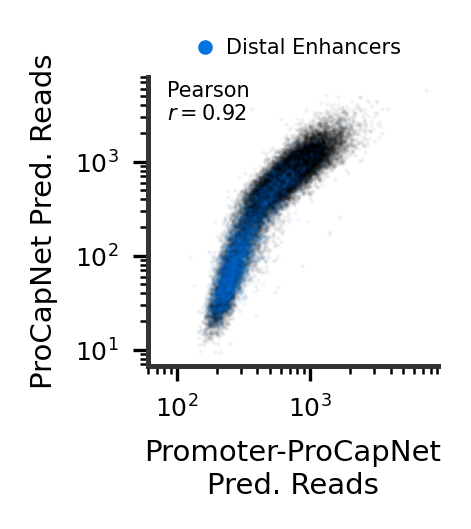

In [34]:
from matplotlib.lines import Line2D

def plot_counts_scatter(promoter_model_counts, normal_model_counts, color_by,
                             title = None, save_path = None, xlabel = None, ylabel = None):

    annots_to_colors = {"All Peaks" : "gray", "PLS" : "#f94144", "dELS" : "#05668d"}
    
    promoter_model_counts = promoter_model_counts.squeeze().flatten()
    normal_model_counts = normal_model_counts.squeeze().flatten()
    
    assert promoter_model_counts.shape == normal_model_counts.shape
    
    pearson_r = np.corrcoef(np.log(promoter_model_counts),
                            np.log(normal_model_counts))[0,1]
    
    plot_params = {
        "xtick.labelsize": 6,
        "ytick.labelsize": 6
    }
    plt.rcParams.update(plot_params)

    plt.figure(figsize=(1.25,1.25), dpi=300)

    colors = np.array(["#000000" for _ in range(len(color_by))])
    colors[color_by] = annots_to_colors["dELS"]
    plt.scatter(promoter_model_counts[~color_by], normal_model_counts[~color_by], c="k",
                alpha = 0.05, s = 1, linewidths=0)
    plt.scatter(promoter_model_counts[color_by], normal_model_counts[color_by], c="#0174DF",
                alpha = 0.05, s = 1, linewidths=0, label="Distal\nEnhancers")

    plt.semilogy()
    plt.semilogx()

    max_lim = max(plt.gca().get_xlim()[1], plt.gca().get_ylim()[1])
    min_lim = min(plt.gca().get_xlim()[0], plt.gca().get_ylim()[0])
    #plt.ylim(min_lim, max_lim)
    plt.xlim(60, plt.gca().get_xlim()[1])

    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=7)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=7)

    if pearson_r is not None:
        print(pearson_r)
        plt.text(60 * 1.4, max_lim * 0.31,
                 "Pearson\n" + r'$r = %0.2f$' % pearson_r,
                 fontsize=5)

    ax = plt.gca()
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)
    ax.spines["left"].set_color("#333333")
    ax.spines["bottom"].set_color("#333333")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.legend(handles=[Line2D([0], [0], marker='o', color='w',
                               label='Distal Enhancers', markeredgewidth=0,
                          markerfacecolor='#0174DF', markersize=3.5)],
               fontsize=5, loc="upper center", handletextpad=0, frameon=False, 
               bbox_to_anchor=(0.5,1.2))
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi=300)
        
    #plt.gca().set_aspect('equal', 'box')
    plt.show()
    
plot_counts_scatter(sorted_promoters_only_pred_counts,
                    sorted_original_pred_counts,
                    ccre_annots["dELS"],
                   xlabel = "Promoter-ProCapNet\nPred. Reads",
                   ylabel = "ProCapNet Pred. Reads",
                    save_path = figures_dir + "4_promoters_only_model_preds_scatter.png")  